Instructions for updating:
non-resource variables are not supported in the long term


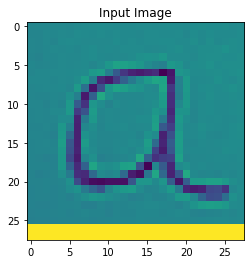

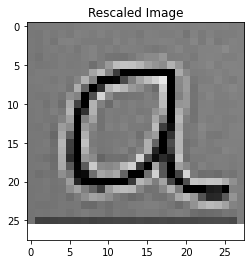

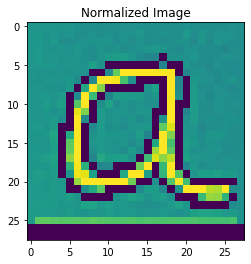

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from model/cnn_model_1_with_tamil.ckpt


In [1]:

# coding: utf-8

# # Loading the image

# In[1]:

from tkinter import *
import matplotlib.pyplot as plt
from PIL import ImageFilter,Image
import numpy as np
import cv2
from IPython import get_ipython
import pyperclip


# In[2]:
def input_emnist(st):
	#opening the input image to be predicted
    im_open = Image.open(st)
    im = Image.open(st).convert('LA') #conversion to gray-scale image
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L',(28,28),(255))


    if width > height: #check which dimension is bigger
        #Width is bigger. Width becomes 20 pixels.
        nheight = int(round((28.0/width*height),0)) #resize height according to ratio width
        if (nheight == 0): #rare case but minimum is 1 pixel
            nheight = 1  
        # resize and sharpen
        img = im.resize((28,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight)/2),0)) #caculate horizontal pozition
        newImage.paste(img, (0,wtop)) #paste resized image on white canvas
    else:
    #Height is bigger. Heigth becomes 20 pixels. 
        nwidth = int(round((28.0/height*width),0)) #resize width according to ratio height
        if (nwidth == 0): #rare case but minimum is 1 pixel
            nwidth = 1
     # resize and sharpen
        img = im.resize((nwidth,28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth)/2),0)) #caculate vertical pozition
        newImage.paste(img, (wleft,0)) #paste resize


# # Normalizing image into pixel values



    tv = list(newImage.getdata())
    tva = [ (255-x)*1.0/255.0 for x in tv]



    for i in range(len(tva)):
        if tva[i]<=0.45:
            tva[i]=0.0
    n_image = np.array(tva)    
    rn_image = n_image.reshape(28,28)
    #displaying input image
    plt.imshow(im_open) 
    plt.title("Input Image")
    plt.show()
    #displaying gray-scale image
    plt.imshow(newImage.convert('LA')) 
    plt.title("Rescaled Image")
    plt.show()
    #displaying normalized image
    plt.imshow(n_image.reshape(28,28))
    plt.title("Normalized Image")
    plt.show()
    # return all the images
    return n_image,im_open,newImage


####  emnist training
# # Loading EMNIST dataset


import warnings
warnings.filterwarnings('ignore')
from mnist import MNIST #this is for loading emnist as input data
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def model_predict(n_image):
	# the below is commented due to the model already been trained
    '''
    emnist = MNIST('C:\\Users\\Anandh\\Anaconda3\\final year project\emnist_data')
    emnist.select_emnist('balanced')

    images,labels = emnist.load_training()
    testIM,testLAB = emnist.load_testing()


    n_images = np.array(images)
    n_labels = np.array(labels)
    testIM = np.array(testIM)
    testLAB = np.array(testLAB)
    '''
    #getting the stored dataset
    get_ipython().magic('store -r n_images')
    get_ipython().magic('store -r n_labels')
    get_ipython().magic('store -r testIM')
    get_ipython().magic('store -r testLAB')

    #fitting data between 0 and 1
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    #train image
    scaler.fit(n_images)
    train_images = scaler.transform(n_images)
    #test image
    scaler.fit(testIM)
    test_images = scaler.transform(testIM)


    testIM[0][567]
    test_images[0][567]


# ## One hot encoding of labels


    from sklearn.preprocessing import OneHotEncoder
    #train data
    shaped_n_labels  = n_labels.reshape(-1,1)
    enc = OneHotEncoder()
    enc.fit(shaped_n_labels)
    train_labels = enc.transform(shaped_n_labels).toarray()
    #test data
    shaped_testLAB = testLAB.reshape(-1,1)
    enc.fit(shaped_testLAB)
    test_labels = enc.transform(shaped_testLAB).toarray()


# ## Functions

# initialising weights
    def init_weights(shape):
        init_random_dist = tf.truncated_normal(shape,stddev=0.1)
        return tf.Variable(init_random_dist)
    # initialising bias
    def init_bias(shape):
        init_bias_vals = tf.constant(0.1,shape=shape)
        return tf.Variable(init_bias_vals)
    #conv2d
    def conv2d(x,W):
        #x -> [bias,height,width,channels]
        #W -> [Filter H,filter W,Channel In,Channel Out]
        return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
    #pooling layer
    def max_pool_2by2(x):
        return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #Convolutional layer
    def convolutional_layer(input_x,shape):
        W=init_weights(shape)
        bias = init_bias([shape[3]])
        return tf.nn.relu(conv2d(input_x,W)+bias)
    #Fully connected layer
    def normal_full_layer(input_layer,size):
        input_size = int(input_layer.get_shape()[1])
        W = init_weights([input_size,size])
        bias = init_bias([size])
        return tf.matmul(input_layer,W) + bias


    # ## Creating model


    #placeholders
    x = tf.placeholder(tf.float32,shape=[None,784])
    y_true=tf.placeholder(tf.float32,shape=[None,59])

    #layers(input)
    x_image = tf.reshape(x,[-1,28,28,1])

    #first convolutional layer
    convo_1 = convolutional_layer(x_image,shape=[5,5,1,32])
    convo_1_pooling = max_pool_2by2(convo_1)

    #second convolutional layer
    convo_2 = convolutional_layer(convo_1_pooling,shape=[5,5,32,64])
    convo_2_pooling = max_pool_2by2(convo_2)

    #fully connected layer
    convo_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
    full_layer_one = tf.nn.relu(normal_full_layer(convo_flat,1024))



    # # Drop out and Optimization


    #drop out (used to overcome overfitting)

    hold_prob = tf.placeholder(tf.float32)
    full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

    y_pred = normal_full_layer(full_one_dropout,59)

    #Loss Function 
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits = y_pred))

    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    train =optimizer.minimize(cross_entropy)

    #initialise variables to execute it
    init = tf.global_variables_initializer()

    steps = 5000


    # # Training and Saving the model


    saver = tf.train.Saver()
    #already the model has been trained using jupyter notebook and the model has been saved. So, the following code snippet is skipped.

    '''
    with tf.Session() as sess:
        sess.run(init)
        batch_size = 120
        for i in range(steps):
            rand_ind = np.random.randint(len(train_images),size=batch_size)
            feed = {x:train_images[rand_ind],y_true:train_labels[rand_ind],hold_prob:0.5}
            sess.run(train,feed_dict=feed)
            
            if i%100 == 0:
                print("On step: {}".format(i))
                match = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
                acc = tf.reduce_mean(tf.cast(match,tf.float32))
                print("Accuracy obtained at {x} is {y}".format(x=i,y=sess.run(acc,feed_dict={x:test_images,y_true:test_labels,hold_prob:1.0})))
                print('\n')
        saver.save(sess,'model/cnn_model.ckpt')
            
    '''

# # Predicting the input image
	
    get_ipython().magic('store -r n_image') #restoring saved input image


    with tf.Session() as sess:
            sess.run(init)
            saver.restore(sess, "model/cnn_model_1_with_tamil.ckpt")
           
            prediction=tf.argmax(y_pred,1)
            var = prediction.eval(feed_dict={x: [n_image],y_true:train_labels,hold_prob: 0.5}, session=sess)


    labels_dict ={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',16:'G',17:'H',18:'I',19:'J',20:'K',21:'l',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'u',31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',46:'t',47:'அ',48:'ஆ',49:'இ',50:'ஈ',51:'உ',52:'ஊ',53:'எ',54:'ஏ',55:'ஐ',56:'ஒ',57:'ஓ',58:'ஔ'}


    s = "The predicted character is {}".format(labels_dict[var[0]])
    return s,labels_dict[var[0]]



st = ""
root = Tk() #tkinter GUI
root.geometry("500x500")
root.winfo_toplevel().title("Handwritten Character Recognition")
label1 = Label( root, text="Enter the name of the file: ")
E1 = Entry(root, bd =5)
def getVal():
    global st
    st= E1.get()
    root.destroy()
submit = Button(root, text ="Submit", command = getVal)
label1.pack()
E1.pack()
submit.pack(side =BOTTOM) 
mainloop()
n_image,image,convo_image = input_emnist(st) #call to Function with name of the file as parameter
res,cpy = model_predict(n_image)
pyperclip.copy(str(cpy)) #copy the predicted character to clipboard
root2 = Tk()
root2.winfo_toplevel().title("Handwritten Character Recognition")
root2.geometry("500x500")
label2 = Label(root2,text = res)
label2.config(font=("Courier", 20))
label2.pack()
mainloop()